In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab.patches import cv2_imshow


In [18]:
### --- CONFIGURATION --- ###
VIDEO_PATH = "/content/drive/MyDrive/2025_biz/Panorama_image1800/VID_20250518_123018.mp4"  # Update as needed


In [4]:
# Advanced feature: Frame selection by blurriness
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

def extract_good_frames(video_path, max_frames=15, blur_thresh=100.0, step=10):
    """Extract non-blurry, well-spaced frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % step == 0 and not is_blurry(frame, blur_thresh):
            frames.append(frame)
            if len(frames) >= max_frames:
                break
        idx += 1
    cap.release()
    print(f"Extracted {len(frames)} frames for panorama.")
    return frames

In [5]:
# Advanced feature: Exposure compensation
def match_exposure(base, img):
    """Match the mean and std of base image to img for better blending."""
    base_yuv = cv2.cvtColor(base, cv2.COLOR_BGR2YCrCb)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    for i in range(3):
        mean_b, std_b = cv2.meanStdDev(base_yuv[:,:,i])
        mean_i, std_i = cv2.meanStdDev(img_yuv[:,:,i])
        img_yuv[:,:,i] = np.clip((img_yuv[:,:,i] - mean_i) * (std_b/std_i) + mean_b, 0, 255)
    return cv2.cvtColor(img_yuv.astype(np.uint8), cv2.COLOR_YCrCb2BGR)


In [12]:
def pyramid_blending(img1, img2, mask, levels=5):
    # Ensure all inputs are float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    mask = mask.astype(np.float32)
    # Make sure mask is 3-channel
    if mask.ndim == 2:
        mask = cv2.merge([mask]*3)
    # Build Gaussian pyramids
    G1, G2, GM = [img1], [img2], [mask]
    for i in range(levels):
        G1.append(cv2.pyrDown(G1[-1]))
        G2.append(cv2.pyrDown(G2[-1]))
        GM.append(cv2.pyrDown(GM[-1]))
    # Build Laplacian pyramids
    L1, L2 = [G1[-1]], [G2[-1]]
    for i in range(levels-1, -1, -1):
        size = (G1[i].shape[1], G1[i].shape[0])
        L1.append(cv2.subtract(G1[i], cv2.pyrUp(G1[i+1], dstsize=size)))
        L2.append(cv2.subtract(G2[i], cv2.pyrUp(G2[i+1], dstsize=size)))
    # Blend pyramids
    LS = []
    for l1, l2, gm in zip(L1, L2, GM):
        # Ensure all are same shape
        if gm.shape != l1.shape:
            gm = cv2.resize(gm, (l1.shape[1], l1.shape[0]))
        ls = l1 * (gm/255.0) + l2 * (1.0 - gm/255.0)
        LS.append(ls)
    # Collapse pyramid
    blended = LS[0]
    for i in range(1, len(LS)):
        size = (LS[i].shape[1], LS[i].shape[0])
        blended = cv2.pyrUp(blended, dstsize=size)
        blended = cv2.add(blended, LS[i])
    return np.clip(blended, 0, 255).astype(np.uint8)


In [7]:
# Feature detection and matching
def detect_and_match(img1, img2):
    # Use ORB (patent-free, fast)
    orb = cv2.ORB_create(3000)
    k1, d1 = orb.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    k2, d2 = orb.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)
    # Match with BFMatcher and crossCheck for robustness
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(d1, d2)
    matches = sorted(matches, key=lambda x: x.distance)
    # Good matches
    pts1 = np.float32([k1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([k2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    return pts1, pts2, matches


In [8]:
def warp_and_blend(base, img, H):
    # Warp the new image onto the base panorama
    h1, w1 = base.shape[:2]
    h2, w2 = img.shape[:2]
    # Corners of img in panorama space
    corners = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners, H)
    # Find size of resulting panorama
    all_corners = np.concatenate((np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2), warped_corners), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    # Translation
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    # Warp images
    panorama = cv2.warpPerspective(img, Ht@H, (xmax-xmin, ymax-ymin))
    panorama[t[1]:h1+t[1], t[0]:w1+t[0]] = base
    # Prepare mask for blending
    mask = np.zeros_like(panorama[:,:,0])
    mask[t[1]:h1+t[1], t[0]:w1+t[0]] = 255
    mask2 = cv2.warpPerspective(np.ones_like(img[:,:,0])*255, Ht@H, (xmax-xmin, ymax-ymin))
    mask_comb = cv2.bitwise_and(mask, mask2.astype(np.uint8))
    # Multi-band blending
    blended = pyramid_blending(panorama, panorama, mask_comb, levels=4)
    return blended


In [9]:
# Advanced feature: Auto-cropping black borders
def autocrop(img):
    # Find non-black area
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    return cropped


In [10]:
def create_panorama_from_video(video_path):
    # 1. Extract good frames
    frames = extract_good_frames(video_path, max_frames=12, blur_thresh=100.0, step=8)
    # 2. Initialize panorama
    base = frames[0]
    for idx, img in enumerate(frames[1:]):
        # Exposure compensation
        img = match_exposure(base, img)
        # Feature detection and matching
        pts1, pts2, matches = detect_and_match(base, img)
        # Estimate Homography with RANSAC
        H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC)
        # Warp and blend
        base = warp_and_blend(base, img, H)
        print(f"Stitched frame {idx+2}/{len(frames)}")
    # 3. Auto-crop
    panorama = autocrop(base)
    return panorama

In [19]:
### --- RUN MAIN PIPELINE --- ###
panorama = create_panorama_from_video(VIDEO_PATH)


Extracted 12 frames for panorama.
Stitched frame 2/12
Stitched frame 3/12
Stitched frame 4/12
Stitched frame 5/12
Stitched frame 6/12
Stitched frame 7/12
Stitched frame 8/12
Stitched frame 9/12
Stitched frame 10/12
Stitched frame 11/12
Stitched frame 12/12


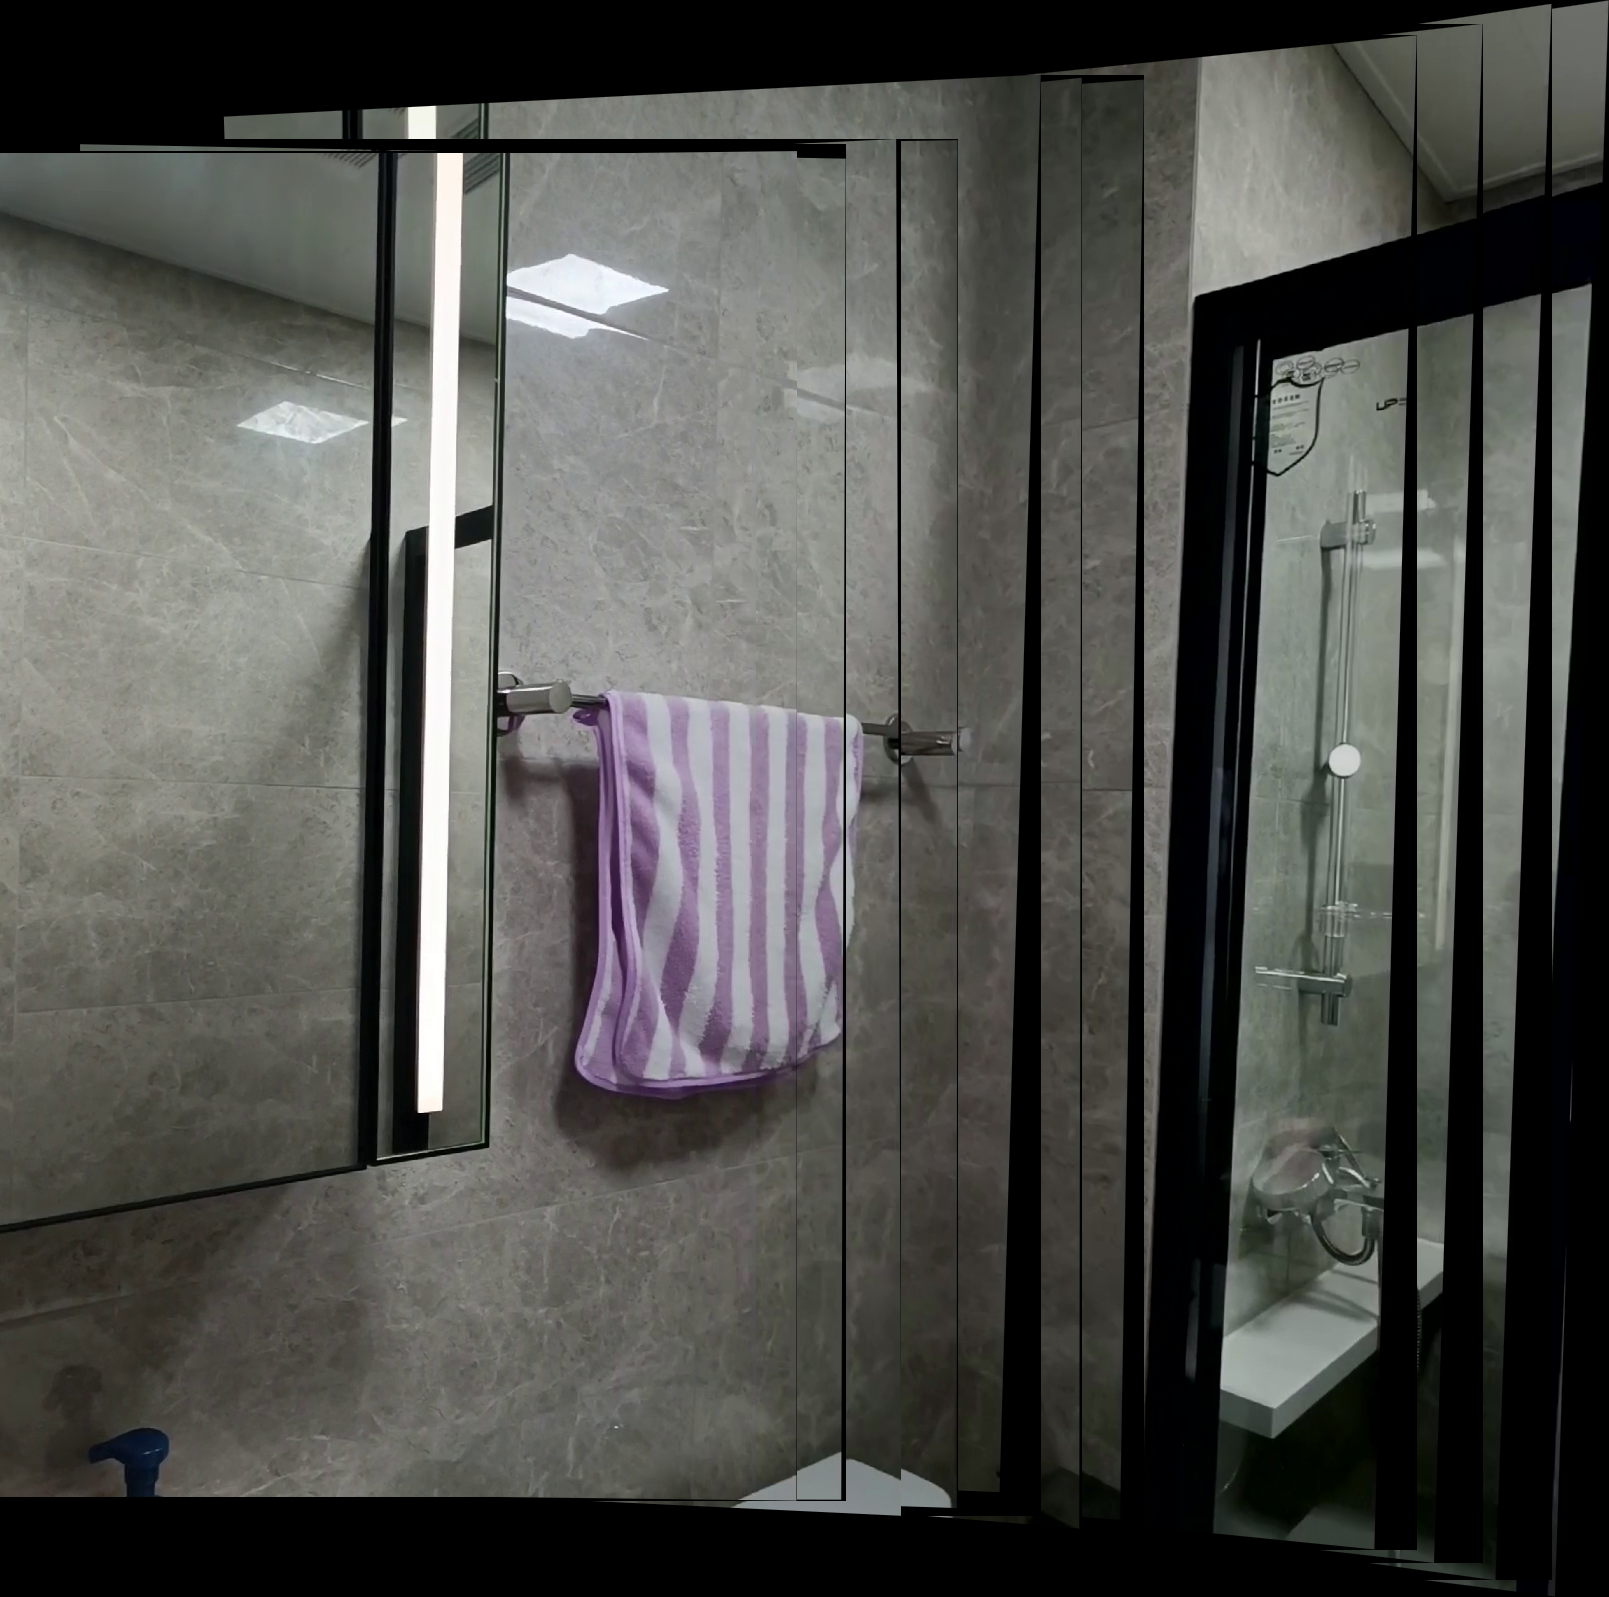

Panorama saved as panorama_result.jpg


In [20]:
# Show result
cv2_imshow(panorama)
cv2.imwrite("/content/panorama_result.jpg", panorama)
print("Panorama saved as panorama_result.jpg")